In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder , LabelEncoder
from sklearn.linear_model import RidgeClassifier
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [5]:
info = pd.read_csv('snp_info.csv')
info

,SNP_id,name,chrom,cm,pos
0,SNP_01,BTA-19852-no-rs,2,67.05460,42986890
1,SNP_02,ARS-USMARC-Parent-DQ647190-rs29013632,6,31.15670,13897068
2,SNP_03,ARS-BFGL-NGS-117009,6,68.28920,44649549
3,SNP_04,ARS-BFGL-NGS-60567,6,77.87490,53826064
4,SNP_05,BovineHD0600017032,6,80.50150,61779512
5,SNP_06,BovineHD0600017424,6,80.59540,63048481
6,SNP_07,Hapmap49442-BTA-111073,6,80.78000,64037334
7,SNP_08,BovineHD0600018638,6,82.68560,67510588
8,SNP_09,ARS-BFGL-NGS-37727,6,86.87400,73092782
9,SNP_10,BTB-01558306,7,62.06920,40827112


In [146]:
train_df = pd.read_csv('train.csv')


In [147]:
test_df = pd.read_csv('test.csv')

전처리

lgbm 중요변수 원핫인코딩 하면 성능 높아짐

In [148]:
y_train = train_df.iloc[:,-1]

In [149]:
x_train = train_df.iloc[:,4:-1]


In [150]:
x_test = test_df.iloc[:,4:]


In [151]:
lbe = LabelEncoder()
for i in list(x_train.columns):
    lbe.fit(x_train[i])
    x_train[i]=lbe.transform(x_train[i])
    x_test[i]=lbe.transform(x_test[i])


In [152]:
lbe_y = LabelEncoder()
y_train = lbe_y.fit_transform(y_train)

In [153]:
ohe = OneHotEncoder()
x_train['trait'] = x_train['trait'].astype('category')
x_test['trait'] = x_test['trait'].astype('category')
x_train['SNP_06'] = x_train['SNP_06'].astype('category')
x_test['SNP_06'] = x_test['SNP_06'].astype('category')
x_train['SNP_02'] = x_train['SNP_02'].astype('category')
x_test['SNP_02'] = x_test['SNP_02'].astype('category')
x_train['SNP_04'] = x_train['SNP_04'].astype('category')
x_test['SNP_04'] = x_test['SNP_04'].astype('category')
x_train['SNP_10'] = x_train['SNP_10'].astype('category')
x_test['SNP_10'] = x_test['SNP_10'].astype('category')
x_train['SNP_03'] = x_train['SNP_03'].astype('category')
x_test['SNP_03'] = x_test['SNP_03'].astype('category')
x_train['SNP_13'] = x_train['SNP_13'].astype('category')
x_test['SNP_13'] = x_test['SNP_13'].astype('category')
x_train['SNP_01'] = x_train['SNP_01'].astype('category')
x_test['SNP_01'] = x_test['SNP_01'].astype('category')
x_train['SNP_12'] = x_train['SNP_12'].astype('category')
x_test['SNP_12'] = x_test['SNP_12'].astype('category')
x_train['SNP_15'] = x_train['SNP_15'].astype('category')
x_test['SNP_15'] = x_test['SNP_15'].astype('category')

x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)

모델링

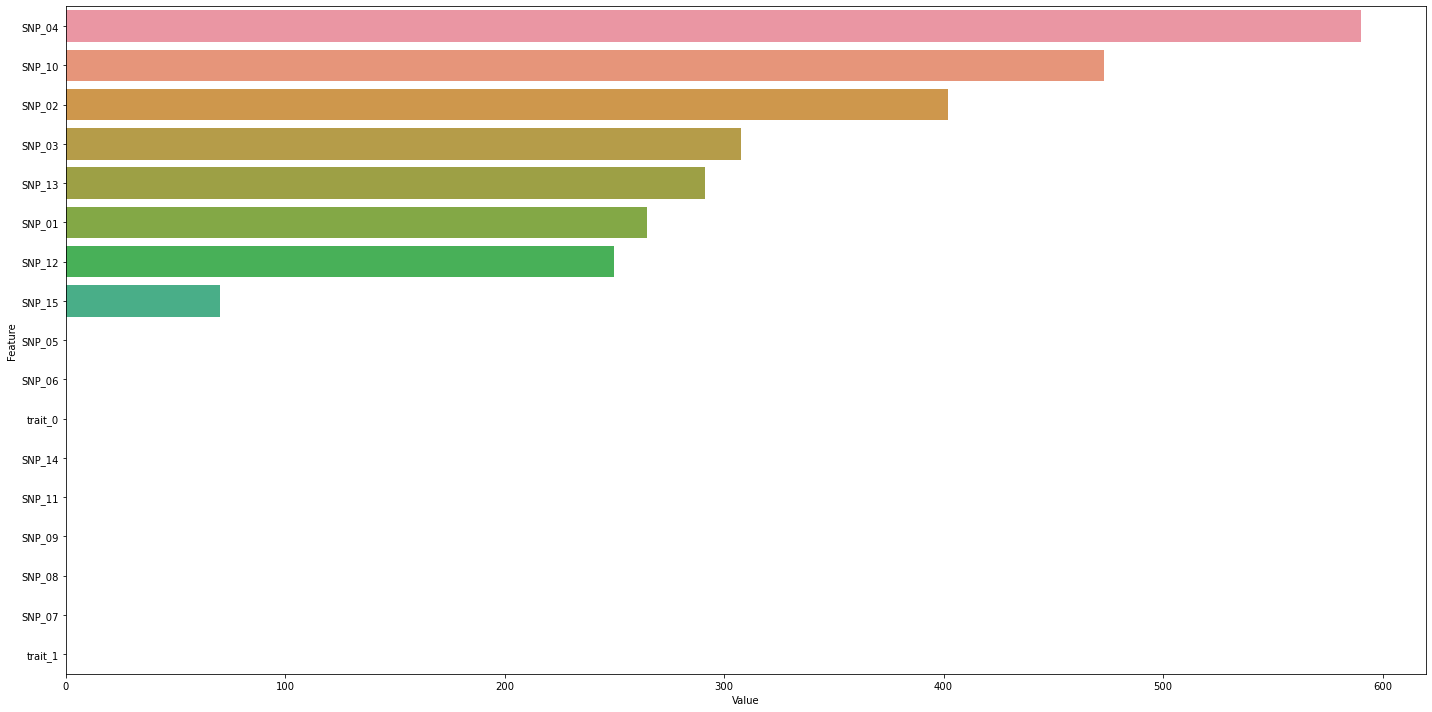

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.tight_layout()
plt.show()


In [43]:
from sklearn.metrics import f1_score

In [118]:
import lightgbm as lgb
import optuna
import time

In [111]:
x_train

,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15,trait_0,trait_1
0,2,1,0,1,1,0,0,2,0,2,1,0,0,0,0,0,1
1,1,1,1,0,0,1,0,1,0,1,0,1,2,0,0,0,1
2,2,2,0,1,2,2,0,1,1,1,0,0,0,0,0,0,1
3,0,2,0,1,0,2,2,0,2,1,2,2,2,0,2,1,0
4,2,2,2,0,2,0,0,0,0,2,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,1,1,0,1,2,1,0,1,0,2,1,1,0,0,0,0,1
258,2,0,1,0,0,1,1,1,0,1,1,0,1,0,1,0,1
259,1,2,0,1,0,1,2,1,1,0,2,2,2,1,2,1,0
260,0,2,0,1,0,2,2,0,1,1,1,1,2,1,2,1,0


In [175]:
start = time.time()
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
lgb=lgb.LGBMClassifier()#Define the parameters
parameters = {'num_leaves':[20,40,60,80,100], 'min_child_samples':[5,10,15],'max_depth':[-1,5,10,20],'max_depth' :  [3,5,7],'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]} #Define the scoring
clf=RandomizedSearchCV(lgb,parameters,scoring='f1_macro')
clf.fit(x_train,y_train)
print(clf.best_params_)
predicted=clf.predict(x_test)

end = time.time()

print(end - start)

{'reg_alpha': 0.03, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.05}
5.801343202590942


In [176]:
clf.best_score_

0.9539302905274554

In [158]:
import lightgbm as lgb

clf = lgb.LGBMClassifier(class_weight='balanced',drop_rate=0.9, min_data_in_leaf=100, max_bin=255,reg_alpha= 0.03,
                                 n_estimators=500,min_sum_hessian_in_leaf=1,importance_type='gain',learning_rate=0.05,bagging_fraction = 0.85,
                                 colsample_bytree = 1.0,feature_fraction = 0.1,lambda_l1 = 5.0,lambda_l2 = 3.0,max_depth =  5,
                                 min_child_samples = 15,min_child_weight = 5.0,min_split_gain = 0.1,num_leaves = 20)
clf.fit(x_train,y_train)

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.03 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=5.0 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.75 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0


LGBMClassifier(bagging_fraction=0.85, class_weight='balanced', drop_rate=0.9,
               feature_fraction=0.1, importance_type='gain', lambda_l1=5.0,
               lambda_l2=3.0, learning_rate=0.05, max_bin=255, max_depth=5,
               min_child_samples=15, min_child_weight=5.0, min_data_in_leaf=100,
               min_split_gain=0.1, min_sum_hessian_in_leaf=1, n_estimators=500,
               num_leaves=20, reg_alpha=0.03, subsample=0.75)

In [ ]:
df_test = pd.read_csv("../input/test.csv").set_index('Id')
X_test = preprocess(df_test)

In [ ]:
from sklearn.linear_model import RidgeClassifier

In [ ]:
start = time.time()
from sklearn.model_selection import GridSearchCV
RC=RidgeClassifier()#Define the parameters
parameters = {'num_leaves':[20,40,60,80,100], 'min_child_samples':[5,10,15],'max_depth':[-1,5,10,20],
             'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]}#Define the scoring
clf=GridSearchCV(RC,parameters,scoring='f1_macro')
clf.fit(x_train,y_train)
print(clf.best_params_)
predicted=clf.predict(x_test)

end = time.time()

print(end - start)

In [85]:
import optuna
def objective(trial):
    X_train,X_vaild,Y_train,Y_valid = train_test_split(x_train,y_train,test_size=0.2)
    dtrain = lgb.Dataset(X_train, label=Y_train)

    param = {
        
       
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_estimators": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7)
    }

    gbm = lgb.LGBMClassifier.fit(param, dtrain)
    preds = gbm.predict(X_vaild)
    pred_labels = np.rint(preds)
    f1 = f1_score(Y_valid, pred_labels,average='macro')
    return f1

In [86]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2022-12-18 17:09:37,670] A new study created in memory with name: no-name-3ddbdc7e-e18a-4a6b-9bd7-4df5ab6ba37b
[W 2022-12-18 17:09:37,678] Trial 0 failed because of the following error: TypeError("fit() missing 1 required positional argument: 'y'")
Traceback (most recent call last):
  File "c:\Users\82102\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\82102\AppData\Local\Temp\ipykernel_9312\2562240050.py", line 16, in objective
    gbm = lgb.LGBMClassifier.fit(param, dtrain)
TypeError: fit() missing 1 required positional argument: 'y'


TypeError: fit() missing 1 required positional argument: 'y'

In [159]:
pred = clf.predict(x_test)

In [166]:
pred = lbe_y.inverse_transform(pred)

In [160]:
df = pd.read_csv('sample_submission.csv')

In [167]:
df['class']=pred

In [168]:
df

,id,class
0,TEST_000,A
1,TEST_001,B
2,TEST_002,C
3,TEST_003,B
4,TEST_004,A
...,...,...
170,TEST_170,B
171,TEST_171,C
172,TEST_172,B
173,TEST_173,B


In [172]:
df.to_csv('종각도전.csv',index=False)